In [135]:
import xarray as xr
import numpy as np
import sys
import glob
import matplotlib.pyplot as plt
import pandas as pd
import dask
from SMYLEutils import calendar_utils as cal
from SMYLEutils import stat_utils as stat

import importlib
importlib.reload(cal)
importlib.reload(stat)

dask.config.set(**{'array.slicing.split_large_chunks': True})

Setting up the parameters for analysis

In [120]:
ystart = 1970 # start year of hindcasts
yend = 2018 # end year of hindcasts
nyears = yend-ystart+1
initmon = 11 # initialization month
domain = "atm" ; freq="month_1" ; var="PSL"
nmems = 20 # the number of hindcast members
memstr = [str(i).zfill(3) for i in np.arange(1,nmems+1,1)] # generating member strings
topdir="/glade/campaign/cesm/development/espwg/SMYLE/archive/"
expname="b.e21.BSMYLE.f09_g17"

Set up longitudes and latitudes for Reykjavik and the Azores

In [35]:
# NAO station index longitudes and latitudes
reyklon = 360.-21.9426 ; reyklat = 64.1466
azorelon = 360.-25.6687 ; azorelat = 25.6687

Set up the dask cluster

In [ ]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '10GB',
    processes = 1,
    queue = 'casper',
    local_directory='$TMPDIR',
    resource_spec='select=1:ncpus=1:mem=10GB',
    project='P04010022',
    walltime='01:00:00',
    interface='ib0')

# scale up
cluster.scale(10)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [ ]:
# do this until you see you've got some workers
client

Sorting out the SMYLE data into an array of the form (init_year, member, time, lat, lon)

In [ ]:
for iyear in np.arange(ystart,yend+1,1):
    print(iyear)
    filelist = [glob.glob(topdir+expname+"."+str(iyear)+'-'+str(initmon)+'.'+imem+'/'+domain+'/proc/tseries/'+freq+'/*.'+var+'.*')[0] for imem in memstr]
    dat = xr.open_mfdataset(filelist, combine='nested', concat_dim='M')
    
    # calculate the time_bnd average to fix the CESM calendar
    timebndavg = np.array(dat.time_bnds.isel(M=0),
                         dtype = 'datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    dat['time'] = timebndavg
    datdjf = cal.season_ts(dat.PSL, 'DJF')
    
    # check ensemble size
    if (dat.M.size != nmems):
        print("You do not have "+str(nmems)+" members for year "+str(iyear)+". Aborting...")
        sys.exit()
        
    # check for consistent size of time dimension
    if (iyear > ystart) and (datdjf.time.size != psl_smyle.time.size):
        print('the size of "time" in year '+str(iyear)+' does not match that of year '+str(ystart)+'. Aborting...')
        sys.exit()
        
    # set up the output arrays
    if (iyear == ystart):
        smyletimes = dat.time # saving times for first member to align ERA5 below
        ntime = datdjf.time.size
        psl_smyle = xr.DataArray(np.zeros([nyears, nmems, ntime, datdjf.lat.size, datdjf.lon.size]),
                                coords=[np.arange(ystart,yend+1,1), np.arange(1,nmems+1,1), datdjf.time, datdjf.lat, datdjf.lon],
                                dims=['init_year','member','time','lat','lon'], name='psl_smyle')
        
    # Fill PSL output array
    psl_smyle[iyear-ystart,:,:,:,:] = np.array(datdjf)

Sort out the ERA5 data into an array of the form (init_year, time, lat, lon)

In [ ]:
topdirera="/glade/campaign/cesm/development/espwg/verification_datasets/mon/SLP/"
dat = xr.open_mfdataset(topdirera+"*.nc").sel(time=slice("1950-01","2020-12"))

# pick out the start and end dates for the smyle hindcasts and calculate the number of years used
starttime = smyletimes.time.isel(time=0) ; endtime = smyletimes.time.isel(time=smyletimes.time.size-1)
nyearshc = (endtime.dt.year - starttime.dt.year).values

# loop through years and fill the ERA5 SLP array
for iyear in np.arange(ystart,yend+1,1):
    print(iyear)
    starttime_era = str(iyear)+"-"+str(starttime.dt.month.values).zfill(2)
    endtime_era = str(iyear+nyearshc)+"-"+str(endtime.dt.month.values).zfill(2)
    datuse = dat.sel(time=slice(starttime_era, endtime_era))
    datdjf = cal.season_ts(datuse.slp, 'DJF')
    
    if (iyear == ystart):
        ntime = psl_smyle.time.size
        psl_era5 = xr.DataArray(np.zeros([nyears,ntime, datdjf.lat.size, datdjf.lon.size]),
                               coords = [np.arange(ystart,yend+1,1), datdjf.time, datdjf.lat, datdjf.lon],
                                dims=['init_year','time','lat','lon'], name='psl_era5')
        
    # fill the array
    psl_era5[iyear-ystart,:,:,:] = np.array(datdjf[:,:,:])

In [55]:
# remove lead dependent climatology for SMYLE
psl_smyle_clim = psl_smyle.mean(["init_year","member"])
psl_smyle = psl_smyle - psl_smyle_clim

In [59]:
# remove climatology for ERA5 (not 100% confident about this.  Should I average over all DJF's or the "lead dependent" DJFs? 
#Doing the latter for now. SHouldn't matter too much.  It's one DJF different.)
psl_era5_clim = psl_era5.mean(["init_year"])
psl_era5 = psl_era5 - psl_era5_clim

In [66]:
reyksmyle = psl_smyle.sel(lon=reyklon, lat=reyklat, method="nearest")
azoresmyle = psl_smyle.sel(lon=azorelon, lat=azorelat, method="nearest")
naosmyle = azoresmyle - reyksmyle

reykera5 = psl_era5.sel(lon=reyklon, lat=reyklat, method="nearest")
azoreera5 = psl_era5.sel(lon=azorelon, lat=azorelat, method="nearest")
naoera5 = azoreera5 - reykera5

Text(0.5, 1.0, 'Cor(ERA5,SMYLE)')

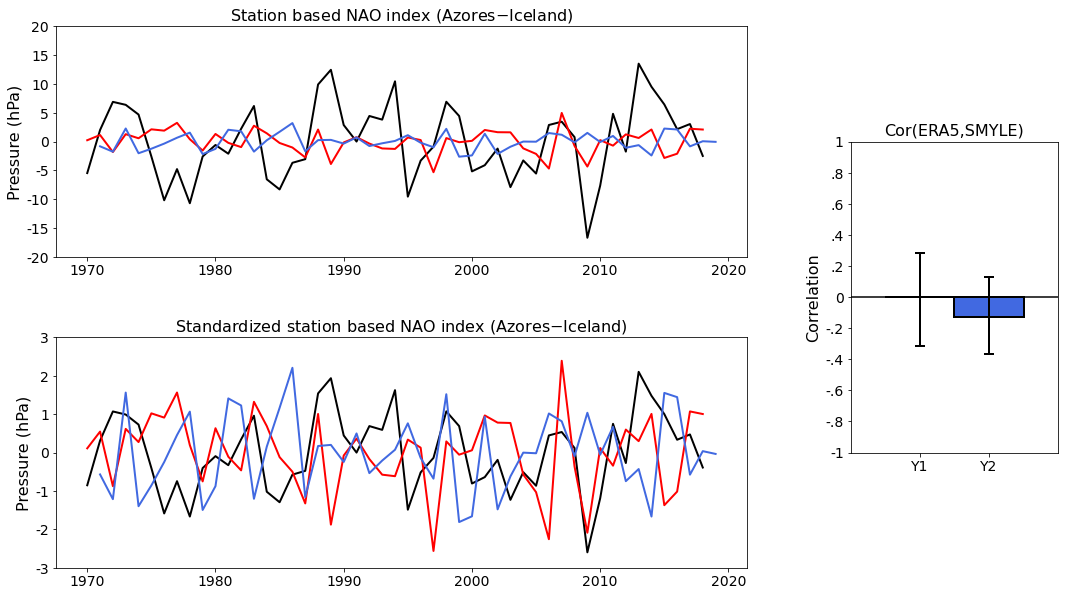

In [136]:
fig = plt.figure(figsize=(16,16))

naosmyle_em_y1 = naosmyle.isel(time=0).mean("member")/100.
naoera5_y1 = naoera5.isel(time=0)/100.
naosmyle_em_y2 = naosmyle.isel(time=1).mean("member")/100.
naoera5_y2 = naoera5.isel(time=1)/100.

# --- regular NAO
ax = fig.add_axes([0.1,0.75,0.6,0.2])

ax.plot(naoera5_y1.init_year, naoera5_y1,linewidth=2, color='black', label='ERA5')
ax.plot(naosmyle_em_y1.init_year, naosmyle_em_y1,linewidth=2.,color='red', label='SMYLE_y1')
ax.plot(naosmyle_em_y1.init_year + 1, naosmyle_em_y2, linewidth=2, color='royalblue', label='SMYLE_y2')

ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])
ax.set_xticklabels(['1970','1980','1990','2000','2010','2020'], fontsize=14)
ax.set_ylim(-20,20)
ax.set_yticks([-20,-15,-10,-5,0,5,10,15,20])
ax.set_yticklabels(['-20','-15','-10','-5','0','5','10','15','20'], fontsize=14)
ax.set_ylabel('Pressure (hPa)', fontsize=16)
ax.set_title('Station based NAO index (Azores$-$Iceland)', fontsize=16)

# --- standardized NAO
ax = fig.add_axes([0.1,0.48,0.6,0.2])

naosmyle_em_y1_std = naosmyle_em_y1/naosmyle_em_y1.std(dim='init_year')
naosmyle_em_y2_std = naosmyle_em_y2/naosmyle_em_y2.std(dim='init_year')
naoera5_y1_std = naoera5_y1/naoera5_y1.std(dim='init_year')


ax.plot(naoera5_y1_std.init_year, naoera5_y1_std,linewidth=2, color='black', label='ERA5')
ax.plot(naosmyle_em_y1_std.init_year, naosmyle_em_y1_std,linewidth=2.,color='red', label='SMYLE_y1')
ax.plot(naosmyle_em_y1.init_year+1, naosmyle_em_y2_std, linewidth=2, color='royalblue', label='SMYLE_y2')
ax.set_xticks([1970, 1980, 1990, 2000, 2010, 2020])
ax.set_xticklabels(['1970','1980','1990','2000','2010','2020'], fontsize=14)
ax.set_ylim(-3,3)
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.set_yticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_ylabel('Pressure (hPa)', fontsize=16)
ax.set_title('Standardized station based NAO index (Azores$-$Iceland)', fontsize=16)


#-----Correlations
cory1 = np.corrcoef(naoera5_y1,naosmyle_em_y1)[0,1]
cory2 = np.corrcoef(naoera5_y2,naosmyle_em_y2)[0,1]
min95y1, max95y1 = stat.cor_ci_bootyears(np.array(naoera5_y1), np.array(naosmyle_em_y1))
min95y2, max95y2 = stat.cor_ci_bootyears(np.array(naoera5_y2), np.array(naosmyle_em_y2))


ax = fig.add_axes([0.79,0.58,0.18,0.27])
ax.plot([0,3],[0,0], color='black')
ax.bar(1,cory1, width=1, bottom=0, align='center', color='red', edgecolor='black', linewidth=2)
ax.errorbar(1, cory1, [[cory1-min95y1], [max95y1-cory1]], color='black', linewidth=2, capsize=5, capthick=2)
ax.bar(2,cory2, width=1, bottom=0, align='center', color='royalblue', edgecolor='black', linewidth=2)
ax.errorbar(2, cory2, [[cory2-min95y2], [max95y2-cory2]], color='black', linewidth=2, capsize=5, capthick=2)
ax.set_ylim(-1,1)
ax.set_xlim(0,3)
ax.set_xticks([1,2])
ax.set_xticklabels(['Y1','Y2'], fontsize=14)
ax.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['-1','-.8','-.6','-.4','-.2','0','.2','.4','.6','.8','1'], fontsize=14)
ax.set_ylabel('Correlation', fontsize=16) ; ax.set_title('Cor(ERA5,SMYLE)', fontsize=16)